# Job Classification and Clustering

We will first make the initial imports for this project. 

In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
from dotenv import load_dotenv

## Data Analysis and Cleaning

We need to load the data for this project by reading the csv file and extracting the data into a newly created Pandas DataFrame.  
We will then analyze the contents of our dataframe by taking a look at a snippet of our data using head() as well as a specific row.  
We will use the BeautifulSoup library to create a function that cleans our data and analyze the same row from before to see the results.

In [2]:
# load the csv file
df = pd.read_csv('data/Engineer_20230826.csv')
df.head()

,RequisitionID,OrigJobTitle,JobTitle,JobDescription
0,NaN,Licensed Stationary Engineer,ENGINEER (all other),Licensed Stationary Engineer \n\n Froedtert So...
1,00000224907,Guidance Navigation and Control (GN&C) Enginee...,ENGINEER (all other),**The Boeing Company** is in search of a **L...
2,00000331804,"Propulsion Engineer - Associate, Mid-Level and...",ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
3,00000336462,Senior Process Controls Engineer,ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
4,00000338951,RF/Microwave Engineer (Level 2 or 3),ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."


In [3]:
# view the pre-cleansed text snippet
print(df['JobDescription'][1])

**The Boeing Company**  is in search of a  **Lead Guidance Navigation and Control (GN&C)**   **Engineer**  to join Boeing in the St. Louis area.  **Boeing Defense and Space Systems**  is growing in the area of aircraft, missile, weapons and autonomous system development and integration.\n\nSelected candidates will work a wide range of programs that will provide state of the art  **Guidance Navigation and Control (GN&C)**  performance analysis and simulation solutions to our customers. They will have visibility across the Boeing enterprise into modern  **GN&C**  and simulation development methods.\n\n**_Come join the Boeing Team!_**\n\n**Position Responsibilities:**\n\n+ Define Guidance, Navigation and Control (GN&C), mission or trajectory requirements and ensure requirements traceability and quality from the system level to component level\n\n+ Design, analyze and guide others in the development of Guidance, Navigation and Control (GN&C) systems, simulations, models & tools\n\n+ Lead t

In [3]:
# function to clean the text so the html/css/js is removed
def clean_html(text):   
    # use BeautifulSoup to remove HTML tags
    cleaned_text = BeautifulSoup(text, 'html.parser').get_text()
    
    # replace '\n', '\\n', and other similar escape sequences with actual newlines
    # cleaned_text = cleaned_text.replace('\\n', '\n')
    
    # strip leading/trailing whitespace or replace multiple newlines with single ones
    cleaned_text = cleaned_text.strip()
    
    return cleaned_text

df['JobDescription'] = df['JobDescription'].apply(clean_html)

/var/folders/m0/46jgs1hd0lvg8pn1fr_jwhrc0000gn/T/ipykernel_37007/2420508730.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleaned_text = BeautifulSoup(text, 'html.parser').get_text()


In [5]:
# view a snippet of cleansed job description
print(df['JobDescription'][1])

**The Boeing Company**  is in search of a  **Lead Guidance Navigation and Control (GN&C)**   **Engineer**  to join Boeing in the St. Louis area.  **Boeing Defense and Space Systems**  is growing in the area of aircraft, missile, weapons and autonomous system development and integration.\n\nSelected candidates will work a wide range of programs that will provide state of the art  **Guidance Navigation and Control (GN&C)**  performance analysis and simulation solutions to our customers. They will have visibility across the Boeing enterprise into modern  **GN&C**  and simulation development methods.\n\n**_Come join the Boeing Team!_**\n\n**Position Responsibilities:**\n\n+ Define Guidance, Navigation and Control (GN&C), mission or trajectory requirements and ensure requirements traceability and quality from the system level to component level\n\n+ Design, analyze and guide others in the development of Guidance, Navigation and Control (GN&C) systems, simulations, models & tools\n\n+ Lead t

In [6]:
df.head()

,RequisitionID,OrigJobTitle,JobTitle,JobDescription
0,NaN,Licensed Stationary Engineer,ENGINEER (all other),Licensed Stationary Engineer \n\n Froedtert So...
1,00000224907,Guidance Navigation and Control (GN&C) Enginee...,ENGINEER (all other),**The Boeing Company** is in search of a **L...
2,00000331804,"Propulsion Engineer - Associate, Mid-Level and...",ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
3,00000336462,Senior Process Controls Engineer,ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."
4,00000338951,RF/Microwave Engineer (Level 2 or 3),ENGINEER (all other),"**Job Description**\n\nAt Boeing, we innovate ..."


## Selecting a random sample

In [4]:
# select 500 random job postings
df_sampled = df.sample(n=500, random_state=42) # random state is for reproducibility
print(df_sampled.shape)

(500, 4)


## API Configuration and Prompt Engineering for Data Arrangement

We will store the output from OpenAI's gpt-4o-mini api into a csv file for reusability and saving api calls.

In [ ]:
# if first time, uncomment line below and run it
# pip install openai

In [5]:
import openai

# Load environment variables from the .env file
load_dotenv()

# Get the API key from environment variable
api_key = os.getenv('OPENAI_API_KEY')

client = openai.OpenAI(api_key=api_key)

def call_openai_api(prompt): 
    try: 
        chat_completion = client.chat.completions.create( 
            messages=[ { "role": "user", "content": "follow the format and DON't other weird delimiters." + prompt, } ], 
            model="gpt-4o-mini", # stream = True 
        )
            
        return chat_completion.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"

In [7]:
call_openai_api('Hello. Return "how can i help you" if this works.')

'how can i help you'

In [ ]:
# Function to send each job posting to GPT-4o mini and categorize it
def categorize_job_posting(job_posting):
    # Build the prompt
    prompt = f"""
    Break up the following job description into the following categories: Marketing, Description, Requirements, Legal.
    For each category, return an array containing the sentences from the job posting corresponding to the category. Return this in JSON formatting

    Job Posting:
    "{job_posting}"

    The format should be as follows:

    **Marketing:** [Any sentence that promotes the job or company]
    **Description:** [Any sentence that explains the job role, company, or purpose of the role]
    **Requirements:** [Any sentence that outlines qualifications or skills needed for the role]
    **Legal:** [Any sentence that includes legal or compliance information such as equal opportunity statements, privacy, or legal disclaimers]
    """

    # Call the GPT-4o mini API with the prompt
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",  # Use the specific GPT-4o mini model name
        messages=[
            {"role": "system", "content": "Follow the format and DON'T use other weird delimiters."},
            {"role": "user", "content": prompt}
        ],
        #max_tokens=1000  # Adjust tokens based on job posting length
    )

    # Extract the response text
    categorized_text = response['choices'][0]['message']['content']
    return categorized_text

# Process all 500 job postings and store the results
df_sampled['Categorized_Posting'] = df_sampled['JobDescription'].apply(categorize_job_posting)

# Save the results to a data frame as JSON objects
df_sampled

In [ ]:
df_sampled['Categorized_Posting'][9666]

## Loading the new data

Now that we have our data file of 500 random postings, we can start loading the new data and later on training the classifier with this data.

In [5]:
# Load the api output CSV file
df_output = pd.read_csv('data/output_file.csv')

# Check the first few rows to ensure the data looks good
print(df_output.head())

                                      JobDescription  \
0  SURVIVABILITY ENGINEER 2\n\nLocation:\n\nNewpo...   
1  Requisition Number: 15838 \n\nRequired Travel:...   
2  **Secure our Nation, Ignite your Future**\n\n*...   
3  Description:\n\nWe are looking for an Instrume...   
4  RH2 is currently seeking an entry-level Staff ...   

                                 Categorized_Posting  
0  ```json\n{\n  "Marketing": [\n    "Want to be ...  
1  ```json\n{\n    "Marketing": [\n        "HII b...  
2  ```json\n{\n    "Marketing": [\n        "Secur...  
3  ```json\n{\n    "Marketing": [\n        "At Ac...  
4  ```json\n{\n  "Marketing": [\n    "Our team is...  


## Data Preprocessing for Classifier Training using FastText

Now we will preprocess the text data to prepare it for training. FastText is a shallow neural network model that generates embeddings for words and sentences. It handles the vectorization of text internally (through word embeddings) and doesn’t require TfidfVectorizer or manual feature extraction.

In [6]:
# we realize that we only have two columns, with categorized_posting having a json structure that we need to convert
print(df_output.columns)

Index(['JobDescription', 'Categorized_Posting'], dtype='object')


### Cleaning JobDescription and Extracting the Description category

In [6]:
import json
import re

# Function to combine non-description categories
def combine_non_description_categories(categorized_posting):
    # Get all non-description categories
    marketing = categorized_posting.get('Marketing', [])
    requirements = categorized_posting.get('Requirements', [])
    legal = categorized_posting.get('Legal', [])
    
    # Combine all non-description texts
    not_description = marketing + requirements + legal
    return not_description
    
# Function to clean and load the JSON-like data
def clean_json_string(json_string):
    # Remove unwanted formatting (like "```json\n" and trailing "```")
    cleaned_string = re.sub(r'```json\n|```', '', json_string)
    try:
        return json.loads(cleaned_string)  # Convert the cleaned string to a dictionary
    except json.JSONDecodeError:
        return {}

# Clean the 'Categorized_Posting' column and convert to a dictionary
df_output['Categorized_Posting'] = df_output['Categorized_Posting'].apply(clean_json_string)

# Extract the 'Description' category from each posting, then extract the other columns separately
df_output['Description'] = df_output['Categorized_Posting'].apply(lambda x: x.get('Description', []))
df_output['Not_Description'] = df_output['Categorized_Posting'].apply(combine_non_description_categories)

# Display the first few rows with the extracted 'Description'. We're essentially comparing the old JobDescription with the new extracted Description category.
df_output[['JobDescription', 'Description']].head()

,JobDescription,Description
0,SURVIVABILITY ENGINEER 2\n\nLocation:\n\nNewpo...,"[With more than 25,000 employees - including t..."
1,Requisition Number: 15838 \n\nRequired Travel:...,[HII Mission Technologies Division is seeking ...
2,"**Secure our Nation, Ignite your Future**\n\n*...",[Seeking an experienced Automation & Orchestra...
3,Description:\n\nWe are looking for an Instrume...,[We are looking for an Instrumentation and Con...
4,RH2 is currently seeking an entry-level Staff ...,[RH2 is currently seeking an entry-level Staff...


### Joining Description Sentences

In [7]:
# for joining the description sentences, convert from list format to single string per job posting
def join_description_sentences(description_list):
    return ' '.join(description_list) if isinstance(description_list, list) else description_list

# Convert lists to strings for both categories
df_output['Description_Text'] = df_output['Description'].apply(join_description_sentences)
df_output['Not_Description_Text'] = df_output['Not_Description'].apply(join_description_sentences)

# Display the first few rows to verify. We've now joined the sentences as strings. 
print(df_output[['JobDescription', 'Description_Text']].head())

                                      JobDescription  \
0  SURVIVABILITY ENGINEER 2\n\nLocation:\n\nNewpo...   
1  Requisition Number: 15838 \n\nRequired Travel:...   
2  **Secure our Nation, Ignite your Future**\n\n*...   
3  Description:\n\nWe are looking for an Instrume...   
4  RH2 is currently seeking an entry-level Staff ...   

                                    Description_Text  
0  With more than 25,000 employees - including th...  
1  HII Mission Technologies Division is seeking a...  
2  Seeking an experienced Automation & Orchestrat...  
3  We are looking for an Instrumentation and Cont...  
4  RH2 is currently seeking an entry-level Staff ...  


## Formatting for FastText and Training the Model

In [8]:

# prepare data for fasttext training, needs a specific format
import fasttext

def prepare_fasttext_data_binary(df, desc_column, not_desc_column, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        # Write Description examples
        for text in df[desc_column]:
            if text and isinstance(text, str):
                cleaned_text = text.replace('\n', ' ').strip()
                f.write(f'__label__Description\t{cleaned_text}\n')
        
        # Write Not Description examples
        for text in df[not_desc_column]:
            if text and isinstance(text, str):
                cleaned_text = text.replace('\n', ' ').strip()
                f.write(f'__label__NotDescription\t{cleaned_text}\n')


# Prepare the training data with both categories
prepare_fasttext_data_binary(
    df_output, 
    'Description_Text', 
    'Not_Description_Text', 
    'data/fasttext_train.txt'
)

# Train the FastText model
model = fasttext.train_supervised(
    input='data/fasttext_train.txt',
    epoch=35,  # Increase epochs
    lr=0.5,    # Adjust learning rate
    wordNgrams=2,
    minCount=2, # Add minimum word count
    loss='ova'  # One-vs-all loss for multiple labels
)

# Save the model
model.save_model("data/job_description_classifier.bin")


Read 0M words
Number of words:  10543
Number of labels: 2
Progress: 100.0% words/sec/thread:  859854 lr:  0.000000 avg.loss:  0.101487 ETA:   0h 0m 0s


## Sentence Tokenization

In [9]:

import nltk
from nltk.tokenize import sent_tokenize

text = "Here is a sentence. Let's check if sentence tokenization works."
sentences = sent_tokenize(text)
print(sentences)


['Here is a sentence.', "Let's check if sentence tokenization works."]


## Extract Job Descriptions and Join Them

In [10]:

import nltk
# extract job postings using fasttext model

def extract_descriptions(job_description):
    sentences = job_description.split('. ') 
    description_sentences = []
    not_description_sentences = []
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    labels = model.predict(sentences)[0]  # Get the labels from the predictions
    
    for sentence, label in zip(sentences, labels):
        if label[0] == '__label__Description':  # Check if the label is 'Description'
            description_sentences.append(sentence.replace('\\n', '\n'))
        else:
            not_description_sentences.append(sentence.replace('\\n', '\n'))
            
    return {
        'Description': description_sentences,
        'Not_Description': not_description_sentences
    }


# Load the trained model
model = fasttext.load_model("data/job_description_classifier.bin")

# Extract job descriptions
df['Extracted_Categories'] = df['JobDescription'].apply(extract_descriptions)

# Join the extracted sentences into a single string
df['Extracted_Description'] = df['Extracted_Categories'].apply(lambda x: '. '.join(x['Description']) if x['Description'] else '')
df['Extracted_Not_Description'] = df['Extracted_Categories'].apply(lambda x: '. '.join(x['Not_Description']) if x['Not_Description'] else '')

# Display a few examples
print(df[['JobDescription', 'Extracted_Description']].head())


                                      JobDescription  \
0  Licensed Stationary Engineer \n\n Froedtert So...   
1  **The Boeing Company**  is in search of a  **L...   
2  **Job Description**\n\nAt Boeing, we innovate ...   
3  **Job Description**\n\nAt Boeing, we innovate ...   
4  **Job Description**\n\nAt Boeing, we innovate ...   

                               Extracted_Description  
0  Licensed Stationary Engineer \n\n Froedtert So...  
1  Louis area. **Boeing Defense and Space Systems...  
2  **Job Description**\n\nAt Boeing, we innovate ...  
3  **Job Description**\n\nAt Boeing, we innovate ...  
4  **Job Description**\n\nAt Boeing, we innovate ...  


## Kmeans Clustering

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Combine the Description and Not_Description_Text into one column (optional)
df['Combined_Text'] = df['Extracted_Description'] + ' ' + df['Extracted_Not_Description']

# Step 2: Transform with TF-IDF
vectorizer = TfidfVectorizer(max_features=800, min_df=5)
X = vectorizer.fit_transform(df['Combined_Text'])  # Use 'Combined_Text' or just 'Description_Text'

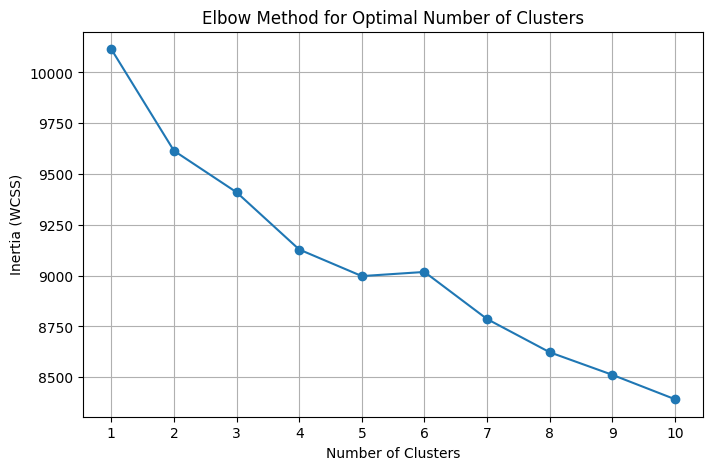

In [12]:
# Step 3: Elbow Method to Determine Optimal Clusters
inertias = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

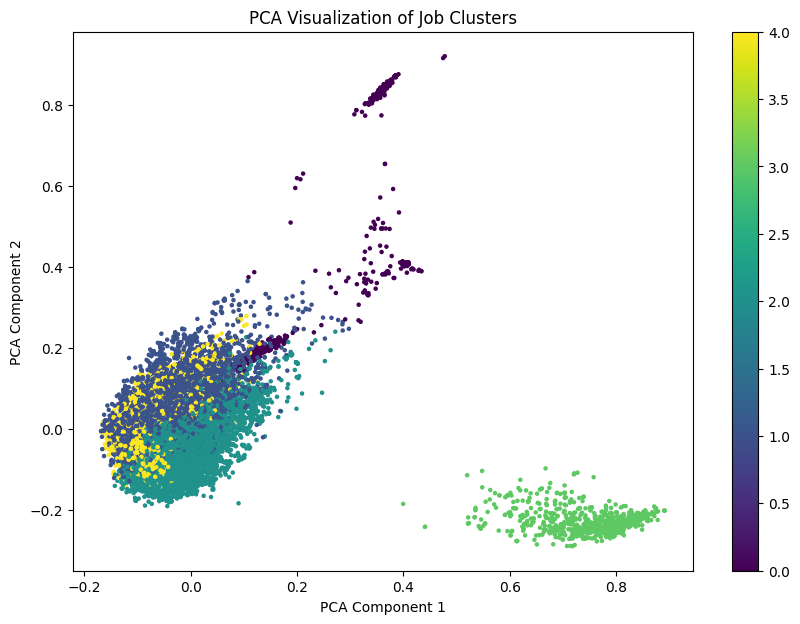

In [13]:
# Step 4: Apply KMeans
num_clusters = 5  # Set based on Elbow Method results
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)
df['Cluster'] = kmeans.labels_

# Step 5: PCA for Visualization
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df['Cluster'], cmap='viridis', s=5)
plt.colorbar()
plt.title("PCA Visualization of Job Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [14]:
# Step 6: Inspect Clusters
terms = vectorizer.get_feature_names_out()
for cluster in range(num_clusters):
    cluster_indices = df[df['Cluster'] == cluster].index
    print(f"Cluster {cluster}:")
    print(df.loc[cluster_indices, 'Combined_Text'].head(5))  # Example descriptions in each cluster
    print()

Cluster 0:
1444    Ttulo de la posicin: Controls Engineer Posicin...
1457    Ttulo de la posicin: Plant Engineer Posicin a ...
2139    RF Data Analytics EngineerSkip to content\n\n ...
2212    Stationary EngineerSkip to content\n\n site\n\...
2652    Network Solutions EngineerSkip to content\n\n ...
Name: Combined_Text, dtype: object

Cluster 1:
0     Licensed Stationary Engineer \n\n Froedtert So...
1     Louis area. **Boeing Defense and Space Systems...
3     **Job Description**\n\nAt Boeing, we innovate ...
31    **Job Description**\n\nAt Boeing, we innovate ...
32    **Job Description**\n\nAt Boeing, we innovate ...
Name: Combined_Text, dtype: object

Cluster 2:
2    **Job Description**\n\nAt Boeing, we innovate ...
4    **Job Description**\n\nAt Boeing, we innovate ...
5    **Job Description**\n\nAt Boeing, we innovate ...
6    **Job Description**\n\nAt Boeing, we innovate ...
7    **Job Description**\n\nAt Boeing, we innovate ...
Name: Combined_Text, dtype: object

Cluster 3:
330

## Suggesting Job Cluster Titles

In [15]:
from nltk.corpus import stopwords
from collections import Counter # Import Counter for word frequency counting

def suggest_cluster_titles(df, text_column, cluster_column, n_words=5):
    stop_words = set(stopwords.words('english'))
    cluster_titles = {}
    
    for cluster in df[cluster_column].unique():
        cluster_texts = df[df[cluster_column] == cluster][text_column]
        words = ' '.join(cluster_texts).lower().split()
        word_counts = Counter(word for word in words if word not in stop_words and len(word) > 3)
        top_words = [word for word, _ in word_counts.most_common(n_words)]
        cluster_titles[cluster] = ' '.join(top_words)
    
    return cluster_titles

# Suggest titles for each cluster
cluster_titles = suggest_cluster_titles(df, 'Extracted_Description', 'Cluster')

# Print suggested titles
for cluster, title in cluster_titles.items():
    print(f"Cluster {cluster}: {title}")

# Add suggested titles to the dataframe
df['Suggested_Title'] = df['Cluster'].map(cluster_titles)

# Display a few examples
print(df[['Cluster', 'Suggested_Title', 'OrigJobTitle']].head(10))

Cluster 1: work engineering support systems technical
Cluster 2: work engineering team support position
Cluster 4: project engineering work design construction
Cluster 0: smith etc. work responsible maintenance
Cluster 3: apple stock design apple's opportunity
   Cluster                             Suggested_Title  \
0        1  work engineering support systems technical   
1        1  work engineering support systems technical   
2        2      work engineering team support position   
3        1  work engineering support systems technical   
4        2      work engineering team support position   
5        2      work engineering team support position   
6        2      work engineering team support position   
7        2      work engineering team support position   
8        2      work engineering team support position   
9        2      work engineering team support position   

                                        OrigJobTitle  
0                       Licensed Stationary E

# LDA Clustering

In [16]:
# pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 3.6 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 3.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 3.5 MB/s eta 0:00:003.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 3.5 MB/s eta 0:00:000:00:010:00:01:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.0
    Uninstalling numpy-2.1.0:
      Successfully uninstalled numpy-2.1.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Optional: Set up stopwords
stop_words = stopwords.words('english')

# Step 1: Vectorize the data using CountVectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words=stop_words, lowercase=True)
X_count = vectorizer.fit_transform(df['Extracted_Description'])  # Use 'Extracted_Description' or 'Combined_Text'

# Feature names (words)
features = vectorizer.get_feature_names_out()

In [17]:
# Step 2: Define and fit LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=0)  # Set number of topics
lda_model.fit(X_count)

# Display the top words for each topic
num_top_words = 10
topics = {}
for idx, topic in enumerate(lda_model.components_):
    top_words = [features[i] for i in topic.argsort()[-num_top_words:][::-1]]
    topics[f"Topic {idx}"] = top_words
    print(f"Topic {idx}: {', '.join(top_words)}")

Topic 0: team, work, solutions, us, business, world, services, data, engineer, technology
Topic 1: engineering, systems, support, design, technical, system, equipment, requirements, process, management
Topic 2: systems, work, test, security, position, support, employees, design, development, requirements
Topic 3: engineering, project, design, projects, work, construction, experience, technical, position, engineer
Topic 4: maintenance, work, equipment, apple, including, time, benefits, building, job, repair


In [18]:
# Get topic distribution for each job description
topic_distributions = lda_model.transform(X_count)

# Assign the topic with the highest probability
df['Assigned_Topic'] = topic_distributions.argmax(axis=1)

# Print sample rows to verify
print(df[['Extracted_Description', 'Assigned_Topic']].head())

                               Extracted_Description  Assigned_Topic
0  Licensed Stationary Engineer \n\n Froedtert So...               4
1  Louis area. **Boeing Defense and Space Systems...               2
2  **Job Description**\n\nAt Boeing, we innovate ...               0
3  **Job Description**\n\nAt Boeing, we innovate ...               2
4  **Job Description**\n\nAt Boeing, we innovate ...               2


In [19]:
import pyLDAvis
import pyLDAvis.lda_model

# Prepare visualization
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(lda_model, X_count, vectorizer)

# Display in Jupyter Notebook
pyLDAvis.display(lda_vis)

# Optional: Save as an HTML file
pyLDAvis.save_html(lda_vis, 'lda_visualization.html')

In [20]:
from collections import Counter

def suggest_lda_titles(df, text_column, topic_column, n_words=5):
    cluster_titles = {}
    for topic in df[topic_column].unique():
        topic_texts = df[df[topic_column] == topic][text_column]
        words = ' '.join(topic_texts).lower().split()
        word_counts = Counter(word for word in words if word not in stop_words and len(word) > 3)
        top_words = [word for word, _ in word_counts.most_common(n_words)]
        cluster_titles[topic] = ' '.join(top_words)
    return cluster_titles

# Generate titles for each LDA topic
lda_titles = suggest_lda_titles(df, 'Extracted_Description', 'Assigned_Topic')

# Add to dataframe
df['Suggested_LDA_Title'] = df['Assigned_Topic'].map(lda_titles)

# Print suggested titles
print(lda_titles)

{4: 'work maintenance including equipment building', 2: 'work systems support engineering team', 0: 'work team solutions engineering technical', 1: 'engineering support work technical design', 3: 'engineering project work design construction'}


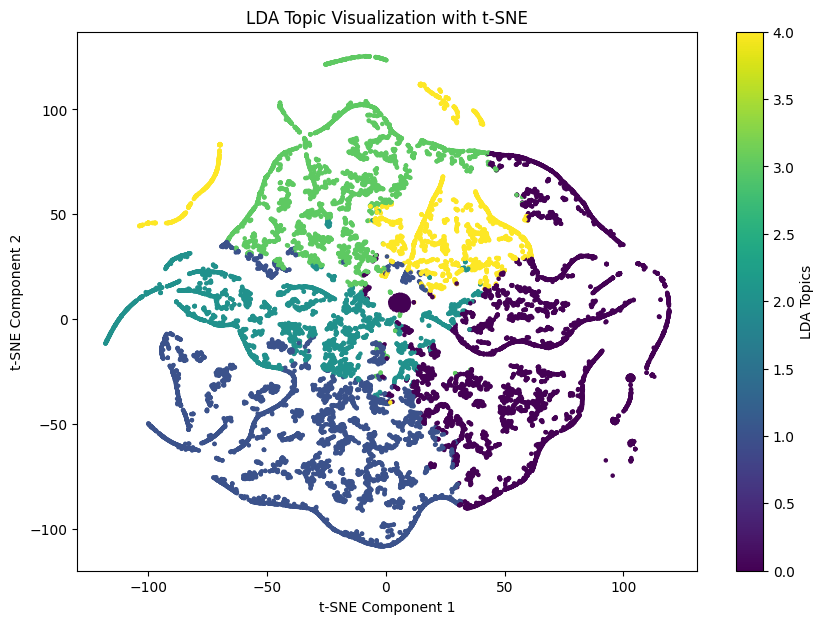

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality of the topic distributions for visualization
tsne = TSNE(n_components=2, random_state=0)
reduced_topics = tsne.fit_transform(topic_distributions)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_topics[:, 0], reduced_topics[:, 1], c=df['Assigned_Topic'], cmap='viridis', s=5)
plt.colorbar(label='LDA Topics')
plt.title("LDA Topic Visualization with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

## Mihili's Job Title Suggestion Code

In [22]:
import openai

# Load environment variables from the .env file
load_dotenv()

# Get the API key from environment variable
api_key = os.getenv('OPENAI_API_KEY')

client = openai.OpenAI(api_key=api_key)

def call_openai_api(cluster, keywords): 
    prompt = f"""
    Given the following job clusters and their top keywords extracted through a TF-IDF vectorizer and topic modeling 
    analysis using LDA, suggest 3 suitable job titles for each cluster that align with the identified themes. Return 
    this in JSON formatting. The format should be as follows:

    "Cluster n: title1, title2, title3"

    The cluster, along with their keywords, are as follows:
    {cluster}: {keywords}
    """
    try: 
        chat_completion = client.chat.completions.create( 
        messages=[ { 
            "role": "user", "content": "follow the format and DON't other weird delimiters." + prompt, 
        } ], 
        model="gpt-4o-mini", 
        )
        parsed_response =  chat_completion.choices[0].message.content
        return parsed_response
    
    except Exception as e: 
        return f"Error: {str(e)}"

In [23]:
import json

for idx, keywords in enumerate(top_words):
    titles = (call_openai_api(f"Cluster {idx + 1}",{', '.join(keywords)} ))
    try:
        parsed_json = json.loads(titles)
        formatted_json = json.dumps(parsed_json, indent=4)
        print(formatted_json)
    except:
        print(titles)

```json
{
    "Cluster 1": "Maintenance Technician, Facility Maintenance Specialist, Equipment Maintenance Manager"
}
```
```json
{
    "Cluster 2": "Workplace Coordinator, Remote Work Specialist, Workflow Analyst"
}
```
```json
{
    "Cluster 3": "Equipment Specialist, Equipment Technician, Equipment Manager"
}
```
```json
{
    "Cluster 4": "Apple Developer, iOS Engineer, Mobile App Designer"
}
```
```json
{
    "Cluster 5": "Inclusion Specialist, Diversity Coordinator, Accessibility Advocate"
}
```
```json
{
    "Cluster 6": "Time Management Specialist, Operations Coordinator, Project Scheduler"
}
```
```json
{
    "Cluster 7": "Benefits Specialist, Employee Benefits Manager, Compensation and Benefits Analyst"
}
```
```json
{
    "Cluster 8": "Construction Manager, Building Engineer, Project Architect"
}
```
```json
{
    "Cluster 9": "Job Coordinator, Job Analyst, Job Consultant"
}
```
```json
{
    "Cluster 10": "Repair Technician, Maintenance Specialist, Equipment Repairer"
}
```